## Analizador de sentimientos en Twitter

### Conectando con twitter

In [2]:
# Importando bibliotecas necesarias
import tweepy
import keys

# Authorizacion utilizando llaves consumer_key y consumer_secret
auth = tweepy.OAuthHandler(keys.consumer_key, keys.consumer_secret)

# Agregando acceso a usuario con llaves access_token y access_token_secret
auth.set_access_token(keys.access_token, keys.access_token_secret)

# Obteniendo una instancia del objeto API de la biblioteca tweepy
api = tweepy.API(auth)

### Función para limpiar los tweets

In [3]:
import re
import emoji
import string

# Función que ayuda a limpiar los tweets
def clean_text(text):
    text = text.replace('\n', '') # remueve saldos de línea
    text = text.replace('#', '')  # remueve caracter hashtag
    text = emoji.replace_emoji(text, replace='')  # remueve emojis
    text = re.sub('RT @[^\s]+', '', text)  # remueve RT @USER
    text = re.sub('@[^\s]+', '', text)  # remueve @USER
    text = re.sub('#[^\s]+', '', text)  # remueve #HASHTAG
    text = re.sub(r'(?:(https|http)\s?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', ' ', text) # remueve url's
    text = text.translate(str.maketrans('', '', string.punctuation)) # remueve !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    text = text.replace('¡', '').replace('¿', '')
    return text.lower().strip()

### Obteniendo y guardando tweets financieros

In [4]:
# Bibilioteca para manipular bases de datos en tablas
import pandas as pd

# Usuarios (periodistas) de twitter mexicanos enfocados en analisis financiero
users = ['mcmaricarmen', 'E_Q_', 'ValeriaMoy', 'DineroEnImagen', 'aguilar_dd', 'MarioMal', 'Rodpac', 'macariomx', 'SOYCarlosMota', 'VictorPiz', 'EconomicasY', 'rominarr', 'elceo__', 'robertoah']

# Lista donde se guardan los tweets
tweets =[]

# Ciclo que obtiene tweets de los usuarios
for user in users :
    for tweet in tweepy.Cursor(api.user_timeline, screen_name = user).items (100):
        tweets.append(tweet.text)

# Lista de tweets limpios
limpios = []

# Se limpian los textos con la funcion limpia_tweet
for tweet in tweets :
    limpios.append(clean_text(tweet))

# Creando un dataframe con los tweets obtenidos
dataframe = pd.DataFrame(limpios, columns = ['tweet'])

# Filtrando únicamente tweets con la palabra dolar y eliminando textos duplicados
dataframe = dataframe[dataframe['tweet'].str.contains('dólar')]
dataframe.drop_duplicates(inplace = True)

# Guardar en un archivo csv los tweets obtenidos
# dataframe.to_csv('../data/mis_tweets_dolar_mx.csv', index = None)

### Se leen los tweets que previamente han sido manualmente a etiquetados

In [5]:
dataframe = pd.read_csv('../data/mis_tweets_dolar_mx_etiquetados.csv')
opiniones_data = dataframe['Opinion'].to_list()
opiniones_target = dataframe['Sentimiento'].to_list()
dataframe.head(10)

Sentimiento                                            Opinion
0            1  el dólar se debilita porque la inflación en es...
1            0  el dólar se fortaleció hoy a nivel internacion...
2            1  desplome en mercados accionarios por riesgo de...
3            1  sigue súper peso el dólar bajó a 1950 pesos en...
4            1  los mercados bursátiles optimistas el dólar re...
5            0  el dólar se está fortaleciendo contra todas la...
6            0  aunque el dólar se está fortaleciendo a nivel ...
7            0  ojo ante la incertidumbre sobre nombramiento d...
8            0  la ratificación de jerome powell como presiden...
9            0  el dólar subió hoy en niveles de 2060 pesos po...

### Preprocesamiento de tweets

In [6]:
# Remoción de las palabras vacías (Stopwords)
from nltk.corpus import stopwords

spanish_stop_words = stopwords.words('spanish')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in spanish_stop_words])
        )
    return removed_stop_words

no_stop_words = remove_stop_words(opiniones_data)

In [7]:
# Filtrando más Stopwords (definidas por el usuario)
otros_stopwords = ['a','acá','ahí','al','algo','algún','alguna','alguno','algunas','algunos','allá','allí','ambos','ante',
                 'antes','aquel','aquella','aquello','aquellas','aquellos','aquí','arriba','así','atrás','aun','aunque',
                 'bien','cada','casi','como','con','cual','cuales','cualquier','cualquiera','cuan','cuando','cuanto','cuanta',
                 'cuantos','cuantas','de','del','demás','desde','donde','dos','el','él','ella','ello','ellas','ellos','en',
                 'eres','esa','ese','eso','esas','esos','esta','esto','estas','estos','este','etc','ha','hasta','la','lo','las',
                 'los','me','mi','mis','mía','mías','mío','míos','mientras','muy','ni','nosotras','nosotros','nuestra',
                 'nuestro','nuestras','nuestros','os','otra','otro','otras','otros','para','pero','pues','que','qué','si','sí',
                 'siempre','siendo','sin','sino','so','sobre','sr','sra','sres','sta','su','sus','te','tu','tus','un','una',
                 'uno','unas','unos','usted','ustedes','vosotras','vosotros','vuestra','vuestro','vuestras','vuestros','y','ya',
                 'yo']

for i in range(len(no_stop_words)):
    for element in otros_stopwords:
        no_stop_words[i] = no_stop_words[i].replace(" " + str(element) + " ", " ")

print("Uno de los texto sin Stopwords:")
no_stop_words[50]

Uno de los texto sin Stopwords:


'fortalecimiento dólar debido temores consecuencias inflación'

### División de los tweets para entrenamiento y validación

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convirtiendo la lista de targets en un tensor de numpy
opiniones_target = np.array(opiniones_target)

# Separación de la información en conjuntos de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(no_stop_words, opiniones_target, test_size=0.20)

### Tokenización de los tweets

In [9]:
from keras.preprocessing.text import Tokenizer

# Preparamos la capa de embeddings (se predefinen 5000 palabras - tokens)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Transformando cada texto en una secuencia de valores enteros
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Vectorización de cada tweet

In [10]:
from keras_preprocessing.sequence import pad_sequences

# Conversión de los conjuntos de entrenamiento a vectores 
maxlen = 11 # máximo 11 palabras por tweet limpio

# Aquellos mayores a 100 son truncados, y los menores les 
# es replicado su último valor para tener arreglos
# bidimensionales del mismo tamaño (Usar el método para padding)
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print("Matriz de valores para las palabras:")
X_train

Matriz de valores para las palabras:


array([[  1,  33, 122, ...,  28,   0,   0],
       [180,   1, 181, ..., 184,   0,   0],
       [  1, 149,  29, ..., 395,   0,   0],
       ...,
       [251,  10,   1, ...,  62, 137, 199],
       [612,   1,  77, ..., 372,   8, 373],
       [  1,  27,   3, ..., 367, 368,   0]])

### Word2Vect

In [11]:
# Lectura del archivo de embeddings
embeddings_dictionary = dict()
embeddings_file = open('../data/Word2Vect_Spanish.txt', encoding="utf8")

### Extracción de características

In [12]:
# Declaración de librerías para manejo de arreglos (Numpy)
from numpy import asarray
from numpy import zeros
# Extracción de las características del archivo de embeddings
# y se agregan a un diccionario (Cada elemento es un vector)
for linea in embeddings_file:
    caracts = linea.split()
    palabra = caracts[0]
    vector = asarray(caracts[1:], dtype='float32')
    embeddings_dictionary [palabra] = vector
embeddings_file.close()

### Matriz de embeddings

In [13]:
# Extracción de la cantidad de palabras en el vocabulario
vocab_size = len(tokenizer.word_index) + 1

# Generación de la matriz de embeddings (De entrada llena de ceros)
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    # Extracción del vector de embeddings para cada palabra
    embedding_vector = embeddings_dictionary.get(word)
    # Si la palbra si existía en el vocabulario
    # se agrega a su vector de embeddings en la matriz
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Red neuronal LSTM

In [14]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense
from tensorflow.keras.layers import Embedding

# Se declara el modelo Secuencial 
model = Sequential()
model._name='Red_LSTM'

# Se declaran las capas del modelo LSTM
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(512, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Se imprime la información del modelo definido
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "Red_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 300)           183900    
                                                                 
 lstm (LSTM)                 (None, 512)               1665024   
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 1,849,437
Trainable params: 1,665,537
Non-trainable params: 183,900
_________________________________________________________________
None


### Entrenamiento del modelo

In [15]:
# Se utiliza el método fit para ajustar los datos del modelo a la configuración definida
history = model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1, validation_split=0.2)
# Se utiliza el método evaluate para determinar la pérdida y el accuracy del modelo
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Epoch 1/50
6/6 [==============================] - 4s 257ms/step - loss: 0.6938 - acc: 0.4587 - val_loss: 0.6813 - val_acc: 0.5732
Epoch 2/50
6/6 [==============================] - 1s 234ms/step - loss: 0.6838 - acc: 0.5413 - val_loss: 0.6626 - val_acc: 0.6707
Epoch 3/50
6/6 [==============================] - 1s 226ms/step - loss: 0.6526 - acc: 0.6391 - val_loss: 0.5864 - val_acc: 0.7439
Epoch 4/50
6/6 [==============================] - 1s 208ms/step - loss: 0.5315 - acc: 0.7737 - val_loss: 0.3656 - val_acc: 0.8171
Epoch 5/50
6/6 [==============================] - 1s 217ms/step - loss: 0.4507 - acc: 0.7829 - val_loss: 0.4007 - val_acc: 0.7805
Epoch 6/50
6/6 [==============================] - 1s 199ms/step - loss: 0.4551 - acc: 0.7706 - val_loss: 0.3660 - val_acc: 0.8171
Epoch 7/50
6/6 [==============================] - 1s 190ms/step - loss: 0.4105 - acc: 0.7920 - val_loss: 0.2995 - val_acc: 0.8659
Epoch 8/50
6/6 [==============================] - 1s 183ms/step - loss: 0.3366 - acc: 0.86

### Resultados del modelo entrenado

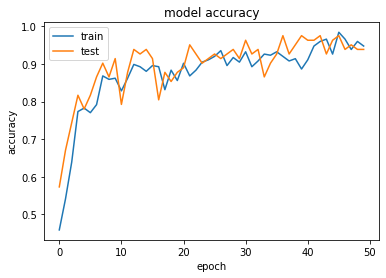

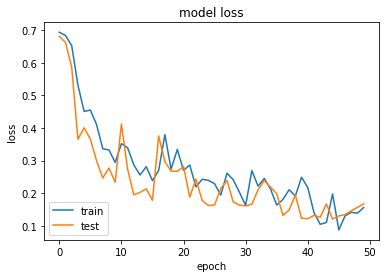

In [16]:
import matplotlib.pyplot as plt

# Se imprime la eficiencia y la pérdida del modelo
# época a época para ver su evolución
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='lower left')
plt.show()

## Usando el analizador de tweets

### Función para el preprocesamiento del texto

In [17]:
word2index = tokenizer.word_index

def texto_tokenizado(texto):
    tokenizado = []
    for word in texto.split():
        if word in word2index:
            tokenizado.append(word2index[word])
        else:
            tokenizado.append(0)
    return pad_sequences([tokenizado], padding='post', maxlen=11)

#### La forma de encontrar el tipo de opinión está determinada por:

$ \text{opinión}
\begin{cases}
 \text{negativa} \quad \text{si predicción} \leq 0.5 \\
 \text{positiva} \quad \text{si predicción} > 0.5
\end{cases}
$

### Función para realizar predicciones

In [18]:
def prediccion(texto_original):
    texto = clean_text(texto_original)
    prediccion = model(texto_tokenizado(texto)).numpy()[0,0]
    if prediccion <= 0.5:
        print(f'Opinión negativa [{prediccion:.4f}] --- {texto_original}')
    else:
        print(f'Opinión positiva [{prediccion:.4f}] --- {texto_original}')

### Textos para probar

In [19]:
textos = [
    'El dólar incrementa, ¡esta mañana subió 25 centavos! 😥😖☹',
    'El debilitamiento del dólar es total, hoy abrió a la baja',
    'La caída de hoy deja dólar débil',
    'Ojo ante la incertidumbre sobre nombramiento de gobernador en  el dólar ya está arriba de 21 pesos',
    'Así el dólar marca nuevo máximo en el año con 21.26 pesos',
    'El índice dólar está en máximos históricos pero cómo afecta esto a la economía mundial',
    'El dólar cerró las operaciones de hoy con una ligera pérdida el tipo de cambio',
    'Mientras tanto el dólar se abarata',
    'Platicamos con  de  sobre la debilidad del dólar presumida por el gobierno',
    'El dólar terminó la  jornada  con ganancias afectado por una mayor aversión a los activos de riesgo'
]

### Realizando predicciones

In [20]:
for texto in textos:
    prediccion(texto)

Opinión negativa [0.1113] --- El dólar incrementa, ¡esta mañana subió 25 centavos! 😥😖☹
Opinión positiva [0.8230] --- El debilitamiento del dólar es total, hoy abrió a la baja
Opinión positiva [0.8699] --- La caída de hoy deja dólar débil
Opinión negativa [0.3963] --- Ojo ante la incertidumbre sobre nombramiento de gobernador en  el dólar ya está arriba de 21 pesos
Opinión negativa [0.1416] --- Así el dólar marca nuevo máximo en el año con 21.26 pesos
Opinión negativa [0.1237] --- El índice dólar está en máximos históricos pero cómo afecta esto a la economía mundial
Opinión positiva [0.5788] --- El dólar cerró las operaciones de hoy con una ligera pérdida el tipo de cambio
Opinión positiva [0.8954] --- Mientras tanto el dólar se abarata
Opinión negativa [0.4829] --- Platicamos con  de  sobre la debilidad del dólar presumida por el gobierno
Opinión negativa [0.0734] --- El dólar terminó la  jornada  con ganancias afectado por una mayor aversión a los activos de riesgo
